In [1]:
import numpy as np
import networkx as nx
import osmnx as ox

# Motif Finding with Analytic Formulas

In this notebook I will try to use the approach by Estrada and Knight to count motifs in some city networks. That is, I will treat the networks as undirected graphs and count subgraphs using analytic formulae that they derived. Only non-nested motifs of $3$ and $4$ nodes will be considered.

In this notebook, let $G$ denote a simple undirected finite graph on $n$ vertices indexed from $1$ to $n$ and $m$ edges. Let $k_i$ denote the degree (i.e. the number of neighborhs) of vertex $i$. Let $A$ denote the adjacency matrix of the graph $G$. With some linear algebra and the definition of the adhacency matrix, I will use that:

$$k_x = \sum_{j=1}^n A_{xj} = \sum_{i=1}^n A_{ix}$$

## Formulas for Subgraph Counting

First, we count the total occurences of each motif. There are in total $8$ triadic and tetradic motifs, and Estrada and Knight present a way of counting each of them using the adjacency matrix of the graph. To denote the number of occurences for a motif $G$ on $n$ nodes I use $\vert M^n_G\vert$. We will consider $6$ classes of motifs:

1) The path graph, a graph in which all vertices are lined up, is denoted by $P$.

2) The complete graph, that is a graph with all possible edges, is denoted by $K$.

3) The star graph, a tree in which all but one vertex have degree one, is denoted by $S$.

4) The cycle graph, a two-regular connected graph, is denoted by $C$.

5) The diamond graph $D$ is a cycle of length $4$ with one diagonal.

6) The tadpole motifs $Td$ are formed by a closed cycle with an additional edge attached to a single vertex.

Notice that, in the case of three-node motifs, we can talk only of the complete graph and the path (which are isomorphic to the cycle and the star, respectively). In the case of four-node motifs all six are present and non-isomorphic.

We reproduce below the formulas for the counting of these motifs, and a python function that performs each calculation taking the graph as an input. Since some formulas depend upon the other counts, I will askf for the motifs vector as an input in all of them---but sometimes we can just set a default value of None.

$$ \vert M^3_P\vert = \dfrac{1}{2}\sum_{i=1}^n k_i(k_i-1)$$

In [2]:
#In this one we will use the degree iterator of nx instead of A.
def count_path3(graph, motifs=None):
    s = 0
    for node in graph:
        degree = graph.degree(node)
        s += degree*(degree - 1)
    count = 0.5*s
    return count

$$ \vert M^3_K\vert = \dfrac{1}{6}\text{Tr}(A^3)$$

In [3]:
#Networkx actually has a function to count triangles! They claim it can do things quite fast (check)
def count_complete3(graph, motifs=None):
    triangles_dict = nx.triangles(graph)
    t = sum(triangles_dict.values())
    count = t/3 #because here we already divided by two!
    return count

$$ \vert M^4_P\vert = \sum_{\{i,j\}\in E(G)} (k_i-1)(k_j-1) - 3\vert M^3_K\vert$$

In [4]:
#Here we do as in the 3-path, but acessing the neighborhood as well.
def count_path4(graph, motifs):
    s = 0
    for node_i in graph:
        for node_j in graph.neighbors(node_i):
            if node_j > node_i:
                degree_i = graph.degree(node_i)
                degree_j = graph.degree(node_j)
                s += (degree_i - 1)*(degree_j - 1)
    count = s - 3*motifs[1]
    return count

$$ \vert M^4_K\vert = \dfrac{1}{24}\sum_{i=1}^n \text{Tr}(A^3_{N(i)})$$

This one is computationally hard. In fact the problem of finding complete subgraphs is, in general, NP-complete. We use the technique that Lanford and Duval also used, as they argued it gives the best runtime. We really need this quantity, as it comes up a lot of times for calculating non-nested motifs.

In [5]:
#I keep this one as it was. The adjacency matrices we compute are for smaller subgraphs so we should be fine. It is still hard.
def count_complete4(graph, motifs=None):
    s = 0
    for node in graph:
        nb = graph[node]
        sub = graph.subgraph(nb)
        Asub = nx.to_numpy_matrix(sub)
        Asub_cube = np.linalg.matrix_power(Asub, 3)
        s += np.trace(Asub_cube)
    count = s/24
    return count

$$ \vert M^4_S\vert = \dfrac{1}{6}\sum_{i=1}^n k_i(k_i-1)(k_i -2)$$

In [6]:
#Using the idea for P_3 this one is trivial to adjust.
def count_star4(graph, motifs=None):
    s = 0
    for node in graph:
        degree = graph.degree(node)
        s += degree*(degree - 1)*(degree - 2)
    count = s/6
    return count

$$ \vert M^4_C\vert = \dfrac{1}{8}\text{Tr}(A^4) - \dfrac{1}{2}\vert M_P^3\vert - \dfrac{1}{4}m$$

In [7]:
#Networkx has a squareclustering method, and we can inspect their source code to get only the square information:
'''
node_iter =  G.nbunch_iter(nodes) 
clustering = {}
for v in node_iter:
    clustering[v] = 0.0
    potential=0
    for u,w in combinations(G[v], 2):
        squares = len((set(G[u]) & set(G[w])) - set([v]))
        clustering[v] += squares
        degm = squares + 1.0
        if w in G[u]:
            degm += 1
        potential += (len(G[u]) - degm) * (len(G[w]) - degm) + squares
    if potential > 0:
        clustering[v] /= potential
return clustering
'''
#We can ignore the degm and potential calculations. The resulting code won't request any info on 3-paths or number of edges.
from itertools import combinations

def count_cycle4(graph, motifs=None):
    s = 0
    for node in graph:
        for u,w in combinations(graph[node], 2):
            squares = len((set(graph[u]) & set(graph[w])) - set([node])) #what this is doing is counting how many neighbors of
                                                                         # node share a common neighbor which is not node. This
                                                                         # is a square.
            s += squares
    count = s/4 #similar to the triangle count    
    return count

$$ \vert M^4_D\vert = \dfrac{1}{4}\sum_{i=1}^n\sum_{j=1}^n A^2_{ij}A_{ij}(A^2_{ij}A_{ij} - 1)$$

In [8]:
#To revamp this one, notice that A_{ij} is just the number of edges (0 or 1) between two nodes i and j. So, if j is not in
# the neighborhood of i we don't even need to take that term into account---it will be zero.
def count_diamond4(graph, motifs=None):
    s = 0
    for node_i in graph:
        for node_j in graph[node_i]:
            #For neighbors, we can find the number of walks of length 2. Note that these are simple graphs, so a walk of
            # length 2 is necessairly a simple 3-path.          
            walks = nx.all_simple_paths(graph, node_i, node_j, 2)
            walk_count = len(list(walks))-1
            #This is A^2_{ij}.
            s += walk_count*(walk_count - 1)
            #Note that, since this is a simple graph, the fact that j is in the neighborhood of i necessairly gives that
            # A_{ij} = 1, so we don't need to include this in our calculations.
    count = s/4
    return count

$$ \vert M^4_{Td}\vert = \dfrac{1}{2}\sum_{k_i > 2} A^3_{ii}(k_i -2)$$

In [9]:
#Again we can use the triangle function, since it also works for individual nodes.
def count_tadpole4(graph, motifs=None):    
    s = 0
    for node in graph:
        degree = graph.degree(node)
        if degree > 2:
            s += nx.triangles(graph, node)*(degree-2)
    count = s #Here we don't need to divide by two. The ii entry of A³ counts closed walks, so a triangle is always counted
              # twice, once in each direction, for an undirected network. 
    return count

For my purposes, we should be able to input a graph and get a vector whose entries are the occurence of each of these motifs (in the order listed above).

In [10]:
def get_motifvector(graph, verbose=False):
    motifs = np.zeros(8)

    motifs[0] = count_path3(graph, motifs)
    motifs[1] = count_complete3(graph, motifs)
    motifs[2] = count_path4(graph, motifs)    
    motifs[3] = count_complete4(graph, motifs)
    motifs[4] = count_star4(graph, motifs)
    motifs[5] = count_cycle4(graph, motifs)
    motifs[6] = count_diamond4(graph, motifs)
    motifs[7] = count_tadpole4(graph, motifs)
    
    return motifs

Let's try these formulas in a simple network

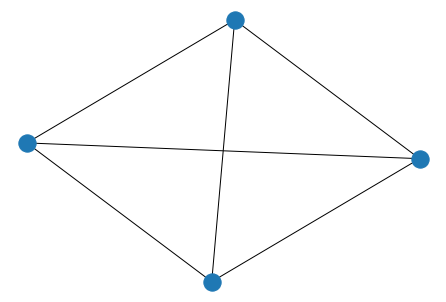

In [11]:
B = nx.Graph()
B.add_nodes_from(list(range(4)))
B.add_edges_from([(0,1),(0,2), (0,3), (1,2), (1, 3), (2, 3)])
nx.draw(B)

In [13]:
test_vec = get_motifvector(B, True)
print(test_vec)

[12.  4. 12.  1.  4.  3.  6. 12.]


In [11]:
G = nx.Graph()
G.add_nodes_from(list(range(8)))
G.add_edges_from([(0,1),(1,2), (2,3), (4,5), (5, 6), (6, 7), (1,5), (1,6), (2,6)])

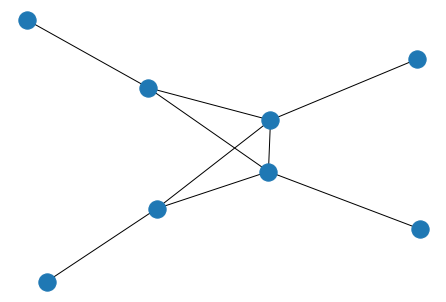

In [12]:
nx.draw(G)
#A = nx.to_numpy_matrix(G)
#A_cube = np.linalg.matrix_power(A, 3)
#print(A_cube)

We can compute by hand that this graph has 18 paths of length 3 and 2 triangles. It has 27 paths of length 4, no complete 4-graph, 10 4-stars, 1 square, 1 diamond, and 10 tadpoles. Now we check our functions:

In [13]:
test_vec = get_motifvector(G, True)
print(test_vec)

[18.  2. 27.  0. 10.  1.  1. 10.]


### Counting Non-Nested Subgraphs

As remarked by Duval and Lawford, we only consider the non-nested subgraphs. That is, a triangle contains three paths of length $3$, and it makes no sense that we consider them if we are counting the triangle. Note that we are only thinking of motifs that are nested in motifs of the same size---so a triangle is not considered to be nested into a diamond, for example. The formula for non-nested motifs, denoted by $\vert \tilde{M}\vert$ are:

$$\vert \tilde{M}^3_P\vert = \vert M^3_P\vert - 3\vert M^3_K\vert$$

In [14]:
def nnest_path3(motifs):
    return motifs[0] - 3*motifs[1]

$$\vert \tilde{M}^4_P\vert = \vert M^4_P\vert - 2\vert M^4_{Td}\vert - 4\vert M^4_C\vert + 6\vert M^4_D\vert -12\vert M^4_K\vert$$

In [15]:
def nnest_path4(motifs):
    return motifs[2] - 2*motifs[7] - 4*motifs[5] + 6*motifs[6] - 12*motifs[3]

$$\vert \tilde{M}^4_S\vert = \vert M^4_S\vert - \vert M^4_{Td}\vert + 2\vert M^4_D\vert - 4\vert M^4_K\vert$$

In [16]:
def nnest_star4(motifs):
    return motifs[4] - motifs[7] + 2*motifs[6] - 4*motifs[3]

$$\vert \tilde{M}^4_C\vert = \vert M^4_C\vert - \vert M^4_D\vert + 3\vert M^4_K\vert$$

In [17]:
def nnest_cycle4(motifs):
    return motifs[5] - motifs[6] + 3*motifs[3]

$$\vert \tilde{M}^4_D\vert = \vert M^4_D\vert - 6\vert M^4_K\vert$$

In [18]:
def nnest_diamond4(motifs):
    return motifs[6] - 6*motifs[3]

$$\vert \tilde{M}^4_{Td}\vert = \vert M^4_{Td}\vert - 4\vert M^4_D\vert + 12\vert M^4_K\vert$$

In [19]:
def nnest_tadpole4(motifs):
    return motifs[7] - 4*motifs[6] + 12*motifs[3]

And we can form a vector of non-nested motifs

In [20]:
def get_nnest_motifvector(motifs):
    nnest_motifs = np.zeros(8)
    nnest_motifs[0] = nnest_path3(motifs)
    nnest_motifs[1] = motifs[1]
    nnest_motifs[2] = nnest_path4(motifs)
    nnest_motifs[3] = motifs[3]
    nnest_motifs[4] = nnest_star4(motifs)
    nnest_motifs[5] = nnest_cycle4(motifs)
    nnest_motifs[6] = nnest_diamond4(motifs)
    nnest_motifs[7] = nnest_tadpole4(motifs)
    return nnest_motifs

In our example network, we have:

In [21]:
nnest_test = get_nnest_motifvector(test_vec)
print(nnest_test)

[12.  2.  9.  0.  2.  0.  1.  6.]


### Expected subgraph count

Typically, when one is deciding whether a subgraph is or is not a motif in a network, we compare its ocurrences to the expected value in a random graph. We reproduce the formulas presented by Duval again, now for random graphs:

$$ \mathbb{E}(\vert M^3_P\vert) = 3{n\choose 3}p^2$$

In [2]:
def random_path3(n,p):
    expectation = n*(n-1)*(n-2)*(p**2)/2
    return expectation

$$ \mathbb{E}(\vert M^3_K\vert) = {n\choose{3}} p^3$$

In [3]:
def random_complete3(n,p):
    expectation = n*(n-1)*(n-2)*(p**3)/6
    return expectation

$$ \mathbb{E}(\vert M^4_P\vert) = 12{n\choose 4}p^3$$

In [4]:
def random_path4(n,p):
    expectation = n*(n-1)*(n-2)*(n-3)*(p**3)/2
    return expectation

$$ \mathbb{E}(\vert M^4_K\vert) = {n\choose 4}p^6$$

In [5]:
def random_path4(n,p):
    expectation = n*(n-1)*(n-2)*(n-3)*(p**6)/24
    return expectation

$$ \mathbb{E}(\vert M^4_S\vert) = 4{n\choose 4}p^3$$

In [6]:
def random_path4(n,p):
    expectation = n*(n-1)*(n-2)*(n-3)*(p**3)/6
    return expectation

$$ \mathbb{E}(\vert M^4_C\vert) = 3{n\choose 4}p^4$$

In [7]:
def random_path4(n,p):
    expectation = n*(n-1)*(n-2)*(n-3)*(p**4)/8
    return expectation

$$ \mathbb{E}(\vert M^4_D\vert) = 6{n\choose 4}p^5$$

In [8]:
def random_path4(n,p):
    expectation = n*(n-1)*(n-2)*(n-3)*(p**5)/4
    return expectation

$$ \mathbb{E}(\vert M^4_{Td}\vert) = 3{n\choose 3}(n-3)p^4$$

In [9]:
def random_path4(n,p):
    expectation = n*(n-1)*(n-2)*(n-3)*(p**4)/2
    return expectation

In [ ]:
def get_random_motifvector(n, m):

    p = 2*m/(n*(n-1))
    
    random_motifs = np.zeros(8)
    
    random_motifs[0] = random_path3(n, p)
    random_motifs[1] = random_complete3(n, p)
    random_motifs[2] = random_path4(n, p)
    random_motifs[3] = random_complete4(n, p)
    random_motifs[4] = random_star4(n, p)
    random_motifs[5] = random_cycle4(n, p)
    random_motifs[6] = random_diamond4(n, p)
    random_motifs[7] = random_tadpole4(n, p)
    
    return random_motifs

## Finding subgraphs in Street Networks

Now that we have the formulas, we should apply them to street networks found through OSMnx

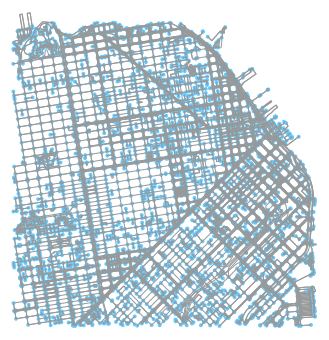

(<Figure size 528.083x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x250449cf048>)

In [22]:
#This is the neighborhood around the Empire State, Geoff Boeing uses it as an example so I just increased the radius
H = ox.graph_from_point((37.79, -122.41), dist=2000, network_type='all')
ox.plot_graph(H)

We need to clean up this graph to satisfy the assumptions we have made in our calculation. Parallel edges and self-loops must be removed.

In [23]:
def no_multiedge(graph):
    return nx.Graph(graph)

In [24]:
def no_selfloop(graph):
    graph.remove_edges_from(nx.selfloop_edges(graph))
    return graph

In [25]:
F = no_multiedge(H)
sl = nx.number_of_selfloops(F) #keep track of this for later on
F = no_selfloop(F)

motifs_F = get_motifvector(F, True)
print(motifs_F)
nnest_F = get_nnest_motifvector(motifs_F)
print(nnest_F)
print("This graph also has", sl, "self-loops.")

[3.6696e+04 3.4200e+02 9.2154e+04 0.0000e+00 2.1000e+04 3.1830e+03
 7.8000e+01 1.8180e+03]
[35670.   342. 76254.     0. 19338.  3105.    78.  1506.]
This graph also has 30 self-loops.


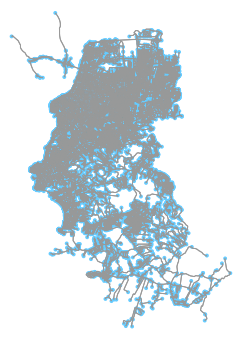

[1.07043e+05 1.68900e+03 2.28975e+05 2.00000e+00 5.13100e+04 5.41800e+03
 2.15000e+02 7.72000e+03]
[1.01976e+05 1.68900e+03 1.93129e+05 2.00000e+00 4.40120e+04 5.20900e+03
 2.03000e+02 6.88400e+03]
This graph also has 58 self-loops.


In [26]:
H2 = ox.graph_from_place('Porto Alegre, Brazil')
ox.plot_graph(H2)

F2 = no_multiedge(H2)
sl2= nx.number_of_selfloops(F2) #keep track of this for later on
F2 = no_selfloop(F2)

motifs_F2 = get_motifvector(F2, True)
print(motifs_F2)
nnest_F2 = get_nnest_motifvector(motifs_F2)
print(nnest_F2)
print("This graph also has", sl2, "self-loops.")

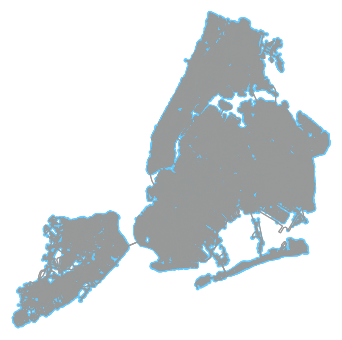

[5.66035e+05 8.22200e+03 1.33080e+06 4.00000e+00 2.99549e+05 3.85250e+04
 8.20000e+02 3.56700e+04]
[5.413690e+05 8.222000e+03 1.110232e+06 4.000000e+00 2.655030e+05
 3.771700e+04 7.960000e+02 3.243800e+04]
This graph also has 785 self-loops.


In [27]:
H3 = ox.graph_from_place('New York City, USA')
ox.plot_graph(H3)

F3 = no_multiedge(H3)
sl3= nx.number_of_selfloops(F3) #keep track of this for later on
F3 = no_selfloop(F3)

motifs_F3 = get_motifvector(F3, True)
print(motifs_F3)
nnest_F3 = get_nnest_motifvector(motifs_F3)
print(nnest_F3)
print("This graph also has", sl3, "self-loops.")